# Perform State of Health Estimation
The goal of this notebook is to estimate how the advanced state of health (ASOH) variables change given only the current and voltage over time.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moirae.estimators.online.filters.distributions import MultivariateGaussian
from moirae.estimators.online.joint import JointEstimator
from moirae.models.ecm import EquivalentCircuitModel
from moirae.models.ecm.advancedSOH import ECMASOH
from moirae.models.ecm.transient import ECMTransientVector
from moirae.models.ecm.ins_outs import ECMInput, ECMMeasurement
from moirae.interface import run_online_estimate
from batdata.data import BatteryDataset
from pathlib import Path
from tqdm import tqdm
import numpy as np

Configuration

In [2]:
estimate_dir = Path('estimates')
estimate_dir.mkdir(exist_ok=True)

In [3]:
initial_asoh = ECMASOH.model_validate_json(Path('initial-asoh.json').read_text())
initial_asoh.mark_updatable('r0.base_values')
initial_asoh.mark_updatable('q_t.base_values')
print(f'Preparing to update {initial_asoh.num_updatable} parameters from: {initial_asoh.updatable_names}')

Preparing to update 10 parameters from: ('q_t.base_values', 'r0.base_values')


## Find cells
Find all the runs then pull out one at example

In [4]:
all_cells = sorted(Path('synth-data/').glob('*.hdf5'))
print(f'Found {len(all_cells)}. Will use {all_cells[0]} as an example')

Found 64. Will use synth-data\bilinear-0.hdf5 as an example


In [5]:
example_data = BatteryDataset.from_batdata_hdf(all_cells[0])
print(f'Loaded a cell with {len(example_data.raw_data)} current and voltage measurements.')

Loaded a cell with 1562592 current and voltage measurements.


## Prepare Estimation Function
We need a function to prepare the [estimator](https://rovi-org.github.io/auto-soh/estimator.html#online-estimators) used for tracking changes in parameters.

In [6]:
def create_estimator(dataset: BatteryDataset):
    """Generate an estimator based on initial parameter estimates

    Args:
        dataset: Dataset on which we are running the estimator. [Not being used for now]
    Returns:
        Estimator ready for use
    """

    # Uncertainties for the parameters
    # Logic from 
    asoh_covariance = [6.25e-04] # Qt: +/- 0.05 Amp-hour
    asoh_covariance += (2.5e-05 * np.ones(initial_asoh.r0.base_values.shape[1])).tolist() # R0
    asoh_covariance = np.diag(asoh_covariance)
    init_transients = ECMTransientVector.from_asoh(initial_asoh)z
    init_transients.soc = np.atleast_2d(1.)
    tran_covariance = np.diag([0.1, 0.1])  # Assume we know SOC to +/-10% and make a very small covariance of hysteresis

    # Make the noise terms
    #  Logic from: https://github.com/ROVI-org/auto-soh/blob/main/notebooks/demonstrate_joint_ukf.ipynb
    voltage_err = 1.0e-03 # mV voltage error
    noise_sensor = ((voltage_err / 2) ** 2) * np.eye(1)
    noise_asoh = 1.0e-10 * np.eye(asoh_covariance.shape[0])
    noise_asoh[0, 0] = 6.25e-04 # Qt value is 10 Amp-hour, so +/- 0.05 Amp-hour is reasonable
    noise_tran = 1.0e-08 * np.eye(2)

    return JointEstimator.initialize_unscented_kalman_filter(
        cell_model=EquivalentCircuitModel(),
        initial_asoh=initial_asoh.model_copy(deep=True),
        initial_inputs=ECMInput(
            time=dataset.raw_data['test_time'].iloc[0], 
            current=0.,
        ),
        initial_transients=init_transients,
        covariance_asoh=asoh_covariance,
        covariance_transient=tran_covariance,
        transient_covariance_process_noise=noise_tran,
        asoh_covariance_process_noise=noise_asoh,
        covariance_sensor_noise=noise_sensor
    )

## Loop over all cells
Generate the state estimates then save the estimates in a new HDF5 file

In [7]:
for path in tqdm(all_cells):
    out_path = estimate_dir / path.name
    if out_path.exists():
        continue

    # Read the cell
    cell = BatteryDataset.from_batdata_hdf(path)
    cell.raw_data = cell.raw_data.query('cycle_number < 10')
    estimator = create_estimator(cell)
    try:
        output, _ = run_online_estimate(cell, estimator)
    except np.linalg.LinAlgError:
        print(f'Cell {path} failed due to linear algebra error')
        continue

    # Append the estimated parameters to the raw data
    cell.raw_data = cell.raw_data.join(output.rename(columns=lambda x: f'est_{x}'))

    # Average the estimated parameters by cycle
    output['cycle_number'] = cell.raw_data['cycle_number']
    by_cycle = output.groupby('cycle_number').mean().reset_index()

    # Add them to the cycle stats
    cell.cycle_stats = cell.cycle_stats.join(by_cycle.drop(columns=['cycle_number']).rename(columns=lambda x: f'est_{x}'))
    cell.to_batdata_hdf(out_path, complevel=9)

  9%|████████████████▏                                                                                                                                                           | 6/64 [00:16<02:38,  2.73s/it]

Cell synth-data\bilinear-13.hdf5 failed due to linear algebra error


 12%|█████████████████████▌                                                                                                                                                      | 8/64 [00:43<05:29,  5.88s/it]

Cell synth-data\bilinear-15.hdf5 failed due to linear algebra error


 19%|████████████████████████████████                                                                                                                                           | 12/64 [02:00<11:16, 13.00s/it]

Cell synth-data\bilinear-19.hdf5 failed due to linear algebra error


 28%|████████████████████████████████████████████████                                                                                                                           | 18/64 [03:35<10:03, 13.13s/it]

Cell synth-data\bilinear-24.hdf5 failed due to linear algebra error


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 19/64 [03:37<07:22,  9.84s/it]

Cell synth-data\bilinear-25.hdf5 failed due to linear algebra error


 33%|████████████████████████████████████████████████████████                                                                                                                   | 21/64 [03:55<06:31,  9.11s/it]

Cell synth-data\bilinear-27.hdf5 failed due to linear algebra error


 38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 24/64 [04:47<08:57, 13.44s/it]

Cell synth-data\bilinear-3.hdf5 failed due to linear algebra error


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                        | 25/64 [04:49<06:22,  9.80s/it]

Cell synth-data\bilinear-30.hdf5 failed due to linear algebra error


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                  | 27/64 [05:17<07:11, 11.66s/it]

Cell synth-data\bilinear-32.hdf5 failed due to linear algebra error


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                | 28/64 [05:27<06:35, 10.98s/it]

Cell synth-data\bilinear-33.hdf5 failed due to linear algebra error


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 31/64 [06:01<05:40, 10.32s/it]

Cell synth-data\bilinear-36.hdf5 failed due to linear algebra error


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 32/64 [06:06<04:40,  8.75s/it]

Cell synth-data\bilinear-37.hdf5 failed due to linear algebra error


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 35/64 [06:47<05:20, 11.05s/it]

Cell synth-data\bilinear-4.hdf5 failed due to linear algebra error


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 37/64 [07:09<04:47, 10.65s/it]

Cell synth-data\bilinear-41.hdf5 failed due to linear algebra error


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 38/64 [07:14<03:48,  8.77s/it]

Cell synth-data\bilinear-42.hdf5 failed due to linear algebra error


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 39/64 [07:19<03:09,  7.59s/it]

Cell synth-data\bilinear-43.hdf5 failed due to linear algebra error


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 40/64 [07:21<02:24,  6.04s/it]

Cell synth-data\bilinear-44.hdf5 failed due to linear algebra error


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 44/64 [08:16<03:31, 10.56s/it]

Cell synth-data\bilinear-48.hdf5 failed due to linear algebra error


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 45/64 [08:19<02:42,  8.53s/it]

Cell synth-data\bilinear-49.hdf5 failed due to linear algebra error


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 47/64 [08:46<02:49,  9.95s/it]

Cell synth-data\bilinear-50.hdf5 failed due to linear algebra error


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 49/64 [09:09<02:38, 10.54s/it]

Cell synth-data\bilinear-52.hdf5 failed due to linear algebra error


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 52/64 [09:49<02:17, 11.42s/it]

Cell synth-data\bilinear-55.hdf5 failed due to linear algebra error


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 54/64 [10:07<01:37,  9.77s/it]

Cell synth-data\bilinear-57.hdf5 failed due to linear algebra error


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 56/64 [10:23<01:06,  8.26s/it]

Cell synth-data\bilinear-59.hdf5 failed due to linear algebra error


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 59/64 [11:07<00:56, 11.29s/it]

Cell synth-data\bilinear-61.hdf5 failed due to linear algebra error


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62/64 [11:59<00:29, 14.78s/it]

Cell synth-data\bilinear-7.hdf5 failed due to linear algebra error


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [12:40<00:00, 11.89s/it]


The output file includes the actual and estimated parameters in the cycle_stats

In [8]:
cell = BatteryDataset.from_batdata_hdf('estimates/bilinear-0.hdf5')
cell.cycle_stats.head()

,actual_q_t.base_values,actual_r0.base_values[0],actual_r0.base_values[1],actual_r0.base_values[2],actual_r0.base_values[3],actual_r0.base_values[4],actual_r0.base_values[5],actual_r0.base_values[6],actual_r0.base_values[7],actual_r0.base_values[8],...,est_r0.base_values[1]_std,est_r0.base_values[2]_std,est_r0.base_values[3]_std,est_r0.base_values[4]_std,est_r0.base_values[5]_std,est_r0.base_values[6]_std,est_r0.base_values[7]_std,est_r0.base_values[8]_std,est_terminal_voltage,est_terminal_voltage_std
0,0.351398,0.049290,0.094716,0.084689,0.076731,0.064186,0.058666,0.050334,0.033678,0.010687,...,0.000025,0.000025,0.000025,0.000025,0.000025,0.000024,6.341766e-06,2.233855e-06,-3.667949e+26,1.787079e+53
1,0.351401,0.049312,0.094758,0.084727,0.076765,0.064215,0.058692,0.050357,0.033693,0.010692,...,0.000025,0.000025,0.000025,0.000025,0.000025,0.000024,2.778242e-06,7.236042e-07,-1.736494e+25,5.598012e+50
2,0.351379,0.049312,0.094759,0.084728,0.076766,0.064216,0.058692,0.050357,0.033693,0.010692,...,0.000025,0.000025,0.000025,0.000025,0.000025,0.000024,8.501850e-07,8.076876e-07,3.584375e+00,4.561363e-06
3,0.351360,0.049334,0.094800,0.084765,0.076800,0.064244,0.058718,0.050379,0.033708,0.010697,...,0.000026,0.000026,0.000026,0.000026,0.000025,0.000024,9.349131e-07,8.893992e-07,3.591911e+00,4.592913e-06
4,0.351338,0.049340,0.094811,0.084775,0.076808,0.064251,0.058725,0.050385,0.033712,0.010698,...,0.000026,0.000026,0.000026,0.000026,0.000026,0.000024,1.000178e-06,9.504968e-07,3.577181e+00,4.727167e-06


Plot estimated compared to actual parameters

Text(0.5, 0, 'Time (hr)')

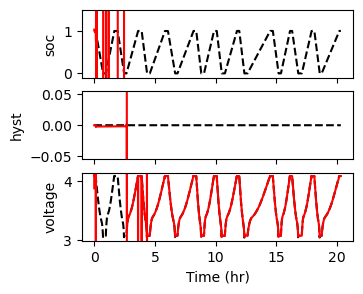

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 3.), sharex=True)

for ax, l in zip(axs, ['soc', 'hyst', 'voltage']):
    ax.plot(cell.raw_data['test_time'] / 3600, cell.raw_data[l], 'k--', label='Actual')
    ax.set_ylim()
    ax.plot(cell.raw_data['test_time'] / 3600, cell.raw_data[f'est_{l}' if l != "voltage" else "est_terminal_voltage"], 'r', label='Actual')

    ax.set_ylabel(l)

axs[0].set_ylim(-0.1, 1.5)
axs[-1].set_xlabel('Time (hr)')